In [1]:
import integrand_builder
import plot_util

In [2]:
compiled = integrand_builder.CompiledIntegrand()
compiled.compile()


Compiling evaluator: "integrand"
Done!
Compiling evaluator: "counter_term"
Done!
Compiling evaluator: "subtracted"
Done!


In [3]:
compiled.p1 = [4, 1, 1, 1]
compiled.p1 = [4, -1, -2, -1]
compiled.m = 1
compiled.thresh = 5

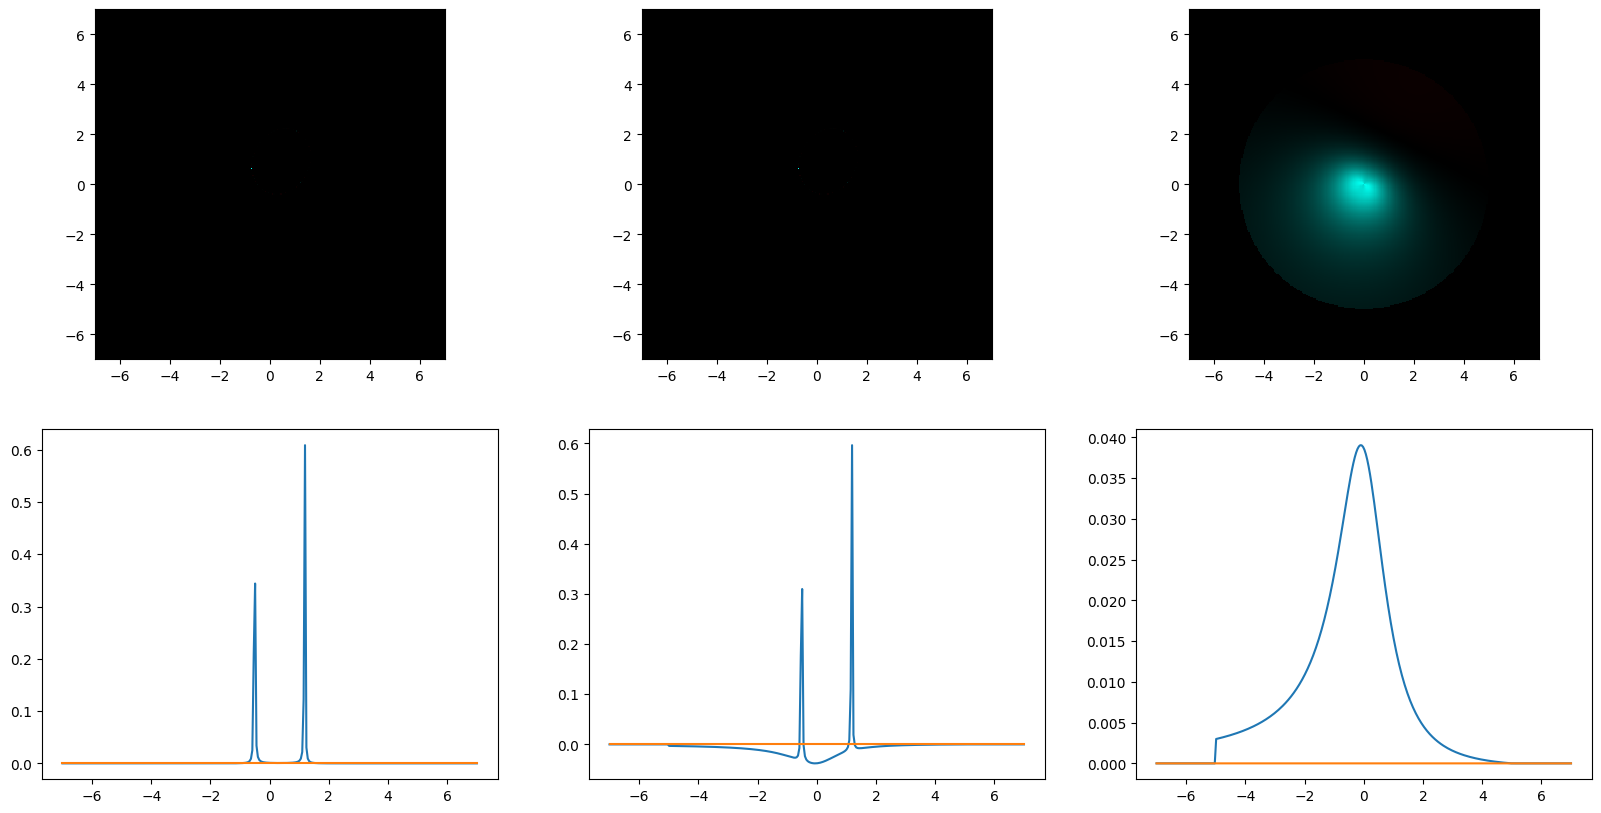

In [4]:
plot_util.plot_threshold_subtraction(compiled, (-7,7), (-7,7))

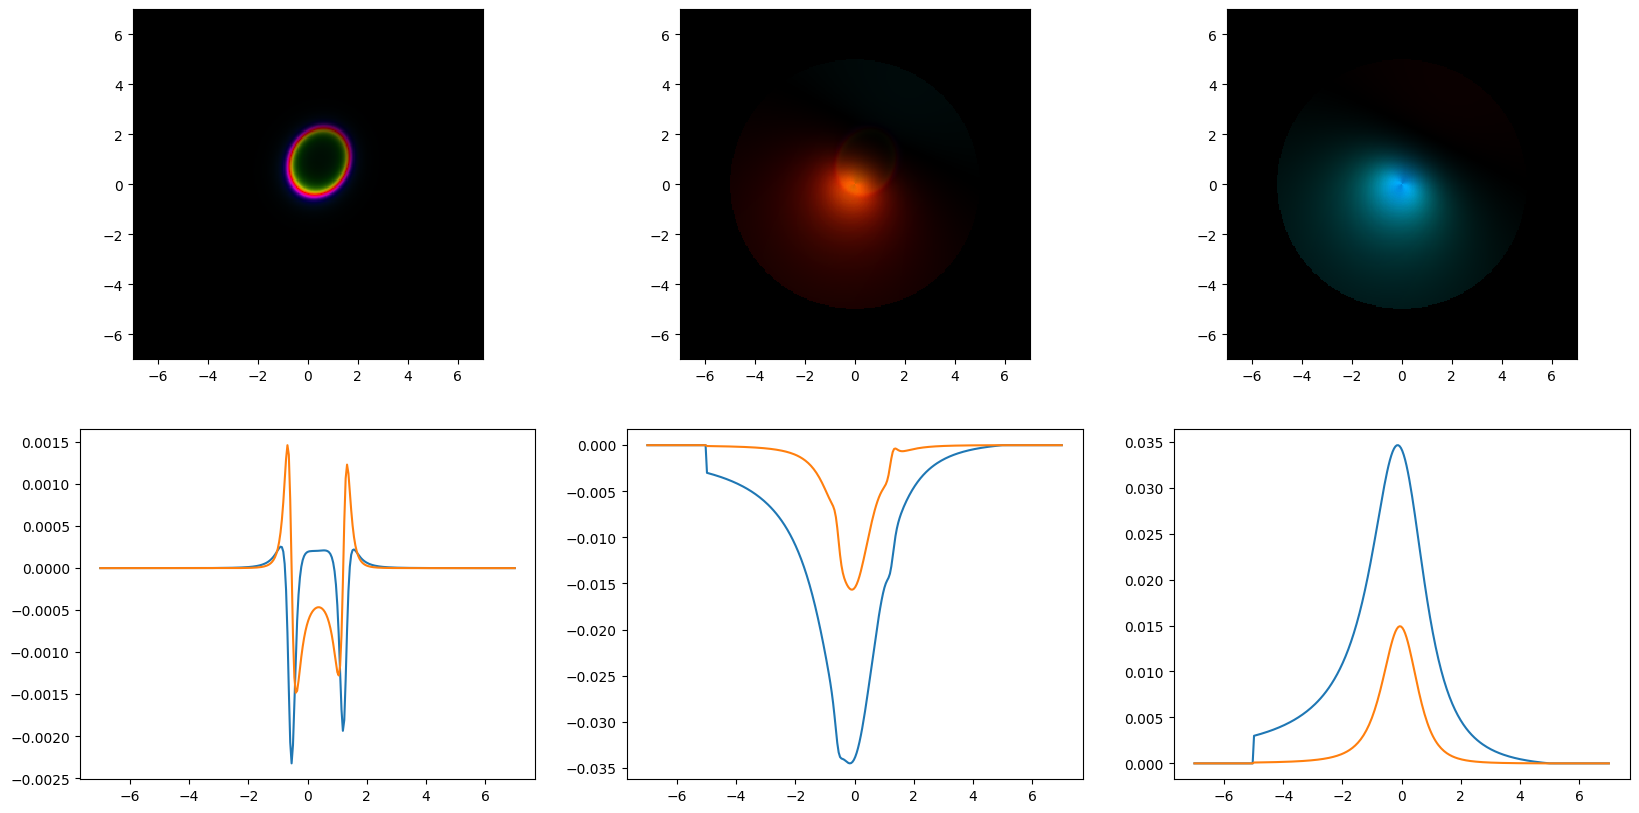

In [5]:
compiled.m = 1-0.2j
plot_util.plot_threshold_subtraction(compiled, (-7,7), (-7,7))

In [ ]:
print(compiled.integrate_naive(epochs=50, samples_per_epoch=50_000))
print(compiled.get_reference())

100%|██████████| 50/50 [00:11<00:00,  4.32it/s]

ComplexIntegratorResult:
value = (-0.001020±0.000013) + i(0.002241±0.000013)
relative absolute error = 0.76% , convergence=11.980, iters=2500000
(-0.0015048593480231683+0.0024462303890325447j)
########################################################################
#                                                                      #
#                        You are using OneLOop                         #
#                                                                      #
# for the evaluation of 1-loop scalar 1-, 2-, 3- and 4-point functions #
#                                                                      #
# author: Andreas van Hameren <hamerenREMOVETHIS@ifj.edu.pl>           #
#   date: 2024-11-23                                                   #
#                                                                      #
# Please cite                                                          #
#    A. van Hameren,                                                   #
#   